In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rebound
import reboundx
import matplotlib.pyplot as plt
import time

# TNOs, Centaurs, and SDOs: https://www.minorplanetcenter.net/iau/MPCORB/Distant.txt
# TNOs only: https://minorplanetcenter.net/iau/lists/TNOs.html

# cat TNOs.txt | cut -c 93- | cut -c -16 > lite_TNOs.txt for inc, e, and a only
# cat TNOs.txt | cut -c 73- | cut -c -36 > lite_TNOs.txt for all six orbital elements
tnos = pd.read_csv('lite_TNOs.txt',delim_whitespace=True)
tnos.head()

,M,Peri.,Node,Incl.,e,a
0,249.1,215.8,218.5,13.7,0.209,39.5
1,202.0,318.7,31.1,8.2,0.233,46.7
2,239.7,218.0,124.0,15.2,0.148,47.9
3,6.0,135.4,353.2,15.2,0.224,47.7
4,28.9,44.8,58.3,10.2,0.078,44.4


In [69]:
def plot_particles():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax1.scatter(xs[0:4], ys[0:4])
    ax1.scatter(xs[5:], ys[5:])
    ax1.set_aspect('equal')
    ax1.set_title('Top-down view')
    ax2.scatter(xs[0:4], zs[0:4])
    ax2.scatter(xs[5:], zs[5:])
    ax2.set_ylim(ax2.get_xlim())
    ax2.set_title('Edge-on view')
    plt.show()

In [70]:
# basic stats on TNOs
print(max(tnos["M"]*np.pi/180), min(tnos["M"]*np.pi/180))
print(max(tnos["Peri."]*np.pi/180), min(tnos["Peri."]*np.pi/180))
print(max(tnos["Node"]*np.pi/180), min(tnos["Node"]*np.pi/180))
print(max(tnos["Incl."]*np.pi/180), min(tnos["Incl."]*np.pi/180))
print(max(tnos["e"]), min(tnos["e"]))
print(max(tnos["a"]), min(tnos["a"]))


6.283185307179586 0.0
6.281439977927592 0.0017453292519943296
6.272713331667619 0.0017453292519943296
0.9459684545809266 0.0017453292519943296
0.44 0.0
49.7 32.0


In [71]:
# convert from a to P with Newtonian version of Kepler's 3rd Law
def a_to_P(a,G,mA,mB):
    return ((a**3)*4*((np.pi)**2)/(G*(mA+mB)))**(1./2)

In [72]:
# instantiate simulation
sim = rebound.Simulation()
rebound.G = 6.674e-11 # SI units
AU = 1.5e11 # in m
sim.integrator = "whfast" # as opposed to IAS15
sim.units = ('m', 's', 'kg')
#sim.dt = 1e10 # At ~100 AU, orbital periods ~1000 yrs, so use a timestep of 0.1% of that, in sec., ie. third of a year
sim.dt = 0.01 * a_to_P(4.49506e12, rebound.G, 1.99e30, 1.024e26) # 1/100 period of Neputune, or on order of an Earth year
sim.N_active = 1 # Make it so dust particles don't interact with one another gravitationally
beta = 0.1

# Sun and gas giants
sim.add(m=1.99e30) # add Sun with mass in kg
sim.add(m=1.898e27, a=7.7857e11, e=4.89e-2) # add Jupiter
sim.add(m=5.683e26, a=1.43353e12, e=5.65e-2) # add Saturn
sim.add(m=8.681e25, a=2.87246e12, e=4.6381e-2) # add Uranus
sim.add(m=1.024e26, a=4.49506e12, e=9.456e-3) # add Neptune

In [73]:
# TNOs
for row in range(len(tnos) - 1800):
    # set orbital parameters
    M = tnos.iloc()[row][0]*np.pi/180 # mean anomaly...without the epoch?
    omega = tnos.iloc()[row][1]*np.pi/180 # arg of pericenter/perihelion
    Omega = tnos.iloc()[row][2]*np.pi/180 # longitude of ascending node
    inc = tnos.iloc()[row][3]*np.pi/180 
    e = tnos.iloc()[row][4]
    a = tnos.iloc()[row][5]*AU
    
    # add object
    sim.add(inc=inc,e=e,a=a,omega=omega,Omega=Omega,M=M)
    
    # add beta property to each KBO object
    sim.particles[row].beta = beta

# add radiation forces with ReboundX
rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces") # set forces
rebx.add_force(rf)
rf.params["c"] = 3.e8 # set forces to speed of light
ps[0].params["radiation_source"] = 1 # reindex radiation source from 0 vector to first particle
beta = 0.1 # set ratio of radiation force to gravitational force

# add mass loss with ReboundX
mm = rebx.load_operator("modify_mass")
rebx.add_operator(mm)

#sim.convert_particle_units('AU', 'yr', 'Msun')
ps = sim.particles
ps[0].params["radiation_source"] = 1 # reindex radiation source from 0 vector to first particle
ps[0].params["tau_mass"] = -1.e4

In [74]:
# for backwards integration, set velocitiy components to opposite signs for each particle
#for p in ps:
#    p.vx = -p.vx
#    p.vy = -p.vy
#    p.vz = -p.vz

139


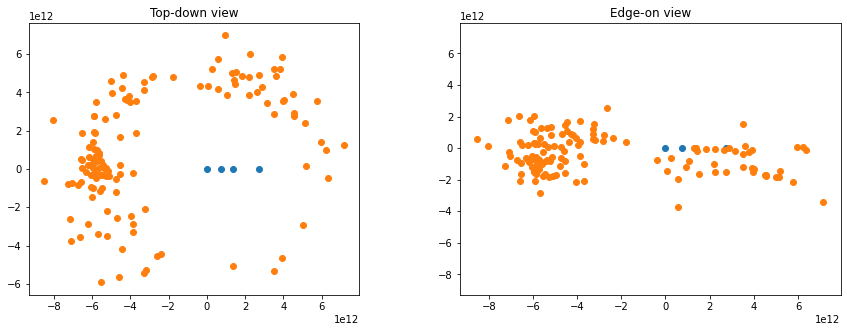

In [75]:
# plot initialized objects
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]
print(len(xs))

%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(xs[0:4], ys[0:4])
ax1.scatter(xs[5:], ys[5:])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(xs[0:4], zs[0:4])
ax2.scatter(xs[5:], zs[5:])
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')
plt.show()

In [ ]:
start = time.clock()
# age of solar system: ~4.571 Gyears, or ~1.44151056e17 seconds
# nothing happens til 1e12 seconds, or 30000 years
Noutputs = int(1e3)
times = np.linspace(0,1e5*a_to_P(4.49506e12, rebound.G, 1.99e30, 1.024e26),Noutputs) # one thousand Netpunian orbits
a = np.zeros(Noutputs)

# integrate
sim.move_to_com()
for i, t in enumerate(times):
    sim.integrate(t)
    print(i, t)
    #a[i] = sim.particles[6].a # track distance for a particle

fig = rebound.OrbitPlot(sim, trails=True)

end = time.clock()
print(end-start)

0 0.0
1 520099943797.78424
2 1040199887595.5685
3 1560299831393.3528
4 2080399775191.137
5 2600499718988.9214
6 3120599662786.7056
7 3640699606584.4897


In [514]:
0.002 * a_to_P(4.49506e12, rebound.G, 1.99e30, 1.024e26)

10391596.877079729

In [515]:
print(ps[0])

<rebound.Particle object, m=3.83106456535e+29 x=4925145838.82 y=-13021113295.3 z=0.0 vx=5.52161049873 vy=7.95999130629 vz=0.0>


In [516]:
a_to_P(4.49506e12, rebound.G, 1.99e30, 1.024e26)

5195798438.539865

In [517]:
(-1e5)*365*24*3600

-3153600000000.0

Text(0.5,1,u'Edge-on view')

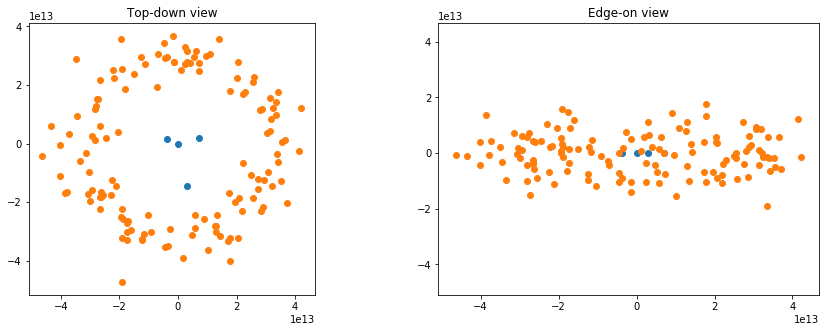

In [518]:
# plot initialized objects
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(xs[0:4], ys[0:4])
ax1.scatter(xs[5:], ys[5:])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(xs[0:4], zs[0:4])
ax2.scatter(xs[5:], zs[5:])
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

In [519]:
ps[0].m

3.8310645653468966e+29